# Meghanjali Chennupati (U30308400)
##  In this assignment I have taken Retail sales forecasting data set.
###  Business problem statement:  This dataset contains lot of historical sales data. It was extracted from a Brazilian top retailer and has many SKUs and many stores. The collborators for this data set are TEVEC system owner. It has total 4 columns date, venda, estoque, precon. 

## Date : It indicates the date .
## Venda (Sales ) : Sales of the company.
## Estoque (Stock): Stocks of the company.
### Precon (Price): Price they got.
### It is a multivariable time series data set we can apply regression analysis on this data set and fit the time series model.
### Here I want to take the sequence of 6 consecutive days and predict the 7th day sales..
### So, time steps= 6 
### rationale is sales column.
### So, In this note book I will do data preparation for data holding 6 time steps that is 6 days in a sequence.
### I will also use two of the techniques which we covered in our class for my data set. So, I am using the RNN , LSTM techniques for my data set.
### Sources or Link to the data set : https://www.kaggle.com/datasets/tevecsystems/retail-sales-forecasting

# First part : As per the first part specified in the question I am going to do data loading and prpearation and no of time steps and rationale i am using

# Load the libraries

In [1]:
import numpy as np
import pandas as pd

# Load the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sales_df= pd.read_csv('/content/drive/My Drive/Assignment3/retailsales.csv')

In [4]:
sales_df.head(5)

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


### Renaming the columns to the undertandable names

In [5]:
sales_df = sales_df.rename(columns={'data' : 'Date', 'venda' : 'Sales', 'estoque' : 'Stock', 'preco' : 'Price'})

In [6]:
sales_df.columns

Index(['Date', 'Sales', 'Stock', 'Price'], dtype='object')

In [7]:
sales_df.isnull().sum()

Date     0
Sales    0
Stock    0
Price    0
dtype: int64

In [8]:

sales_df['Date'] = pd.to_datetime(sales_df['Date'])

In [9]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    937 non-null    datetime64[ns]
 1   Sales   937 non-null    int64         
 2   Stock   937 non-null    int64         
 3   Price   937 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 29.4 KB


In [10]:
#set date as index

sales_df.set_index('Date', inplace=True)

### Considering the parameters of this problem we find that our first sample (observation) will be the feature values for the first 6 rows of the dataframe, and the second sample (observation) will be the next 6 rows starting at the second row, etc.

## Let's begin by converting the dataframe to a numpy array.

In [11]:
arr2D = sales_df.to_numpy() # convert the dataframe to a numpy array
arr2D

array([[0.000e+00, 4.972e+03, 1.290e+00],
       [7.000e+01, 4.902e+03, 1.290e+00],
       [5.900e+01, 4.843e+03, 1.290e+00],
       ...,
       [1.280e+02, 4.095e+03, 2.390e+00],
       [2.700e+02, 3.825e+03, 2.390e+00],
       [1.830e+02, 3.642e+03, 2.390e+00]])

##  The 2D data above is not not our input to the recurrent network - we have three feaures, but no observations. Observations will be the sequences length number of rows.

### This might be easier to understand if we look at how we can manually create observations for our recurrent network training.

In [12]:
arr2D[0:6,:]  # this would be the first observation

array([[0.000e+00, 4.972e+03, 1.290e+00],
       [7.000e+01, 4.902e+03, 1.290e+00],
       [5.900e+01, 4.843e+03, 1.290e+00],
       [9.300e+01, 4.750e+03, 1.290e+00],
       [9.600e+01, 4.654e+03, 1.290e+00],
       [1.450e+02, 4.509e+03, 1.290e+00]])

In [13]:
arr2D[1:7,:]  # this would be the second observation

array([[7.000e+01, 4.902e+03, 1.290e+00],
       [5.900e+01, 4.843e+03, 1.290e+00],
       [9.300e+01, 4.750e+03, 1.290e+00],
       [9.600e+01, 4.654e+03, 1.290e+00],
       [1.450e+02, 4.509e+03, 1.290e+00],
       [1.790e+02, 4.329e+03, 1.290e+00]])

In [14]:
arr2D[2:8,:]  # this would be the third observation, etc

array([[5.900e+01, 4.843e+03, 1.290e+00],
       [9.300e+01, 4.750e+03, 1.290e+00],
       [9.600e+01, 4.654e+03, 1.290e+00],
       [1.450e+02, 4.509e+03, 1.290e+00],
       [1.790e+02, 4.329e+03, 1.290e+00],
       [3.210e+02, 4.104e+03, 1.290e+00]])

##
But, this would be better to put into a function as follows:
    
    

In [15]:
def create_sequences(data, seq_length):
    obs = []
    print(obs)    
    for i in range(len(data)-seq_length-1):
        obs.append(data[i:(i+seq_length)+1])
    return np.array(obs)

# As i mentioned in description I am using 6 time steps 6 days sequences to tell 7th day sales.

In [16]:
RNN_input = create_sequences(arr2D, 6) # 6 tells time steps as i am storing 6 days in sequence for telling 7th day sales
RNN_input

[]


array([[[0.000e+00, 4.972e+03, 1.290e+00],
        [7.000e+01, 4.902e+03, 1.290e+00],
        [5.900e+01, 4.843e+03, 1.290e+00],
        ...,
        [9.600e+01, 4.654e+03, 1.290e+00],
        [1.450e+02, 4.509e+03, 1.290e+00],
        [1.790e+02, 4.329e+03, 1.290e+00]],

       [[7.000e+01, 4.902e+03, 1.290e+00],
        [5.900e+01, 4.843e+03, 1.290e+00],
        [9.300e+01, 4.750e+03, 1.290e+00],
        ...,
        [1.450e+02, 4.509e+03, 1.290e+00],
        [1.790e+02, 4.329e+03, 1.290e+00],
        [3.210e+02, 4.104e+03, 1.290e+00]],

       [[5.900e+01, 4.843e+03, 1.290e+00],
        [9.300e+01, 4.750e+03, 1.290e+00],
        [9.600e+01, 4.654e+03, 1.290e+00],
        ...,
        [1.790e+02, 4.329e+03, 1.290e+00],
        [3.210e+02, 4.104e+03, 1.290e+00],
        [1.250e+02, 4.459e+03, 1.090e+00]],

       ...,

       [[9.800e+01, 9.170e+02, 2.390e+00],
        [1.330e+02, 1.550e+03, 2.390e+00],
        [1.300e+02, 1.420e+03, 2.390e+00],
        ...,
        [9.700e+01, 2.893e

In [17]:
RNN_input.shape

(930, 7, 3)

##
Review the data we have created above. We have 930 'observations', each with 7 time steps and 3 features (sales,stock, price). The last row of each observation is the target value we want to predict. We only need the sales value from the last row of each observation (the other values are not needed - because if you're trying to predict tomorrow's sales, you don't have any measures from tomorrow, because it's the future :) ).

Let's now extract our target variable. In this case, we want to predict the next day's sales, so we will extract the last sales value from each sequence (observation).

In [18]:
y = RNN_input[:,-1,0] # the 6 is the index of the column, and the 0 is the index of the row
y

array([179., 321., 125.,  88., 188., 121., 134.,  80.,  82.,  94., 159.,
       199., 104.,  70., 127.,  96.,  75., 198., 168., 125.,  86., 222.,
       272., 209., 369., 217.,  97., 117., 100.,  64.,  35.,  54.,  55.,
         8.,  43., 107., 116.,  87.,  66.,  44.,  33.,  13.,  53.,  72.,
        50.,  15.,  12.,  71.,  37.,  83.,  94.,  59.,  49.,  65.,  55.,
        77., 122.,  83.,  75.,  48.,  45.,  78., 122., 116.,  48.,  29.,
        91.,  59.,  68., 137.,  56.,  13.,  45.,  25.,  25., 174., 138.,
        64.,  77.,  62., 119.,  89., 133., 180., 121.,  72.,  91.,  53.,
        47.,  42., 124.,  97., 119.,  34.,  18.,  24.,  57.,  61.,  30.,
        96.,   0.,  37.,  30.,  38.,  88.,  64.,  13.,  20.,  31., 129.,
        94., 129., 126.,  70.,  48., 123.,  87.,  65., 102.,  78.,  49.,
         0.,  68., 102.,  88., 170., 152.,  90., 101.,  71.,  48.,  40.,
        93.,  45.,  58.,  53.,  42.,  52.,  29.,  91.,  75.,  75., 179.,
       252., 202., 161., 331., 271., 146.,   2.,   

In [19]:
X = RNN_input[:,0:6,0:3] # the 6 is the index of the column, and the 0 is the index of the row
X

array([[[0.000e+00, 4.972e+03, 1.290e+00],
        [7.000e+01, 4.902e+03, 1.290e+00],
        [5.900e+01, 4.843e+03, 1.290e+00],
        [9.300e+01, 4.750e+03, 1.290e+00],
        [9.600e+01, 4.654e+03, 1.290e+00],
        [1.450e+02, 4.509e+03, 1.290e+00]],

       [[7.000e+01, 4.902e+03, 1.290e+00],
        [5.900e+01, 4.843e+03, 1.290e+00],
        [9.300e+01, 4.750e+03, 1.290e+00],
        [9.600e+01, 4.654e+03, 1.290e+00],
        [1.450e+02, 4.509e+03, 1.290e+00],
        [1.790e+02, 4.329e+03, 1.290e+00]],

       [[5.900e+01, 4.843e+03, 1.290e+00],
        [9.300e+01, 4.750e+03, 1.290e+00],
        [9.600e+01, 4.654e+03, 1.290e+00],
        [1.450e+02, 4.509e+03, 1.290e+00],
        [1.790e+02, 4.329e+03, 1.290e+00],
        [3.210e+02, 4.104e+03, 1.290e+00]],

       ...,

       [[9.800e+01, 9.170e+02, 2.390e+00],
        [1.330e+02, 1.550e+03, 2.390e+00],
        [1.300e+02, 1.420e+03, 2.390e+00],
        [6.200e+01, 1.358e+03, 2.390e+00],
        [9.700e+01, 2.893e+03, 2.39

# Split the data in to train and test data

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
y_train = y_train.reshape(-1,1)
y_train

array([[125.],
       [  0.],
       [ 61.],
       [168.],
       [ 26.],
       [  6.],
       [ 32.],
       [101.],
       [172.],
       [217.],
       [121.],
       [159.],
       [116.],
       [  0.],
       [218.],
       [ 61.],
       [142.],
       [102.],
       [ 95.],
       [  0.],
       [ 64.],
       [ 77.],
       [113.],
       [  7.],
       [ 52.],
       [174.],
       [ 13.],
       [206.],
       [ 89.],
       [ 65.],
       [240.],
       [105.],
       [ 47.],
       [102.],
       [190.],
       [ 40.],
       [  0.],
       [ 42.],
       [107.],
       [ 57.],
       [ 45.],
       [ 63.],
       [155.],
       [  0.],
       [127.],
       [ 73.],
       [111.],
       [ 58.],
       [ 73.],
       [ 48.],
       [  0.],
       [  0.],
       [ 89.],
       [ 66.],
       [ 62.],
       [  1.],
       [ 80.],
       [ 47.],
       [ 30.],
       [ 67.],
       [187.],
       [ 37.],
       [ 16.],
       [381.],
       [ 34.],
       [  0.],
       [ 7

In [22]:
y_test = y_test.reshape(-1,1)
y_test


array([[ 71.],
       [102.],
       [ 35.],
       [ 84.],
       [  0.],
       [ 60.],
       [ 20.],
       [  1.],
       [  0.],
       [ 30.],
       [122.],
       [ 11.],
       [239.],
       [266.],
       [  7.],
       [154.],
       [ 57.],
       [ 78.],
       [ 95.],
       [  0.],
       [186.],
       [116.],
       [ 44.],
       [336.],
       [ 84.],
       [  1.],
       [112.],
       [111.],
       [163.],
       [391.],
       [  0.],
       [ 92.],
       [152.],
       [ 95.],
       [ 56.],
       [103.],
       [ 57.],
       [181.],
       [  0.],
       [ 56.],
       [ 85.],
       [189.],
       [271.],
       [ 49.],
       [  5.],
       [  0.],
       [119.],
       [130.],
       [209.],
       [ 80.],
       [209.],
       [  3.],
       [127.],
       [212.],
       [ 59.],
       [ 88.],
       [  0.],
       [141.],
       [118.],
       [ 52.],
       [135.],
       [  0.],
       [  0.],
       [ 65.],
       [ 67.],
       [335.],
       [ 6

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(744, 6, 3)
(186, 6, 3)
(744, 1)
(186, 1)


# Standardization or Normalization of data using Min Max scaler

In [24]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = X_scaler.fit_transform(X_train.reshape(-1, 6))
X_test_scaled = X_scaler.transform(X_train.reshape(-1, 6))


#y_scaler = MinMaxScaler(feature_range=(0, 1)) # I don't necessarily need to rescale the y values, but I may test doing this in the future
#y_scaler.fit(y_train.reshape(-1, 1))

In [25]:
y_scaler = MinMaxScaler(feature_range=(0, 1)) # I don't necessarily need to rescale the y values, but I may test doing this in the future
y_scaler.fit(y_train.reshape(-1, 1))

MinMaxScaler()

In [26]:
X_train_scaled

array([[0.0904059 , 0.14886552, 0.43288591, 0.20295203, 0.13364693,
        0.43288591],
       [0.05535055, 0.1294964 , 0.43288591, 0.10885609, 0.1213337 ,
        0.43288591],
       [0.17896679, 0.10791367, 0.43288591, 0.28597786, 0.08646929,
        0.43288591],
       ...,
       [0.10516605, 0.24100719, 0.43288591, 0.11254613, 0.23256779,
        0.43288591],
       [0.05535055, 0.22841727, 0.43288591, 0.17712177, 0.21499723,
        0.43288591],
       [0.        , 0.21098506, 0.43288591, 0.06826568, 0.20586608,
        0.43288591]])

In [27]:
X_train_scaled.reshape(-1, 6, 3)

array([[[0.0904059 , 0.14886552, 0.43288591],
        [0.20295203, 0.13364693, 0.43288591],
        [0.05535055, 0.1294964 , 0.43288591],
        [0.10885609, 0.1213337 , 0.43288591],
        [0.17896679, 0.10791367, 0.43288591],
        [0.28597786, 0.08646929, 0.43288591]],

       [[0.        , 0.00124516, 0.5       ],
        [0.        , 0.00124516, 0.5       ],
        [0.        , 0.00124516, 0.5       ],
        [0.        , 0.00124516, 0.5       ],
        [0.        , 0.00124516, 0.46644295],
        [0.        , 0.00124516, 0.46644295]],

       [[0.17896679, 0.27600996, 0.36577181],
        [0.2195572 , 0.25940786, 0.36577181],
        [0.06273063, 0.25470393, 0.43288591],
        [0.03321033, 0.25221361, 0.43288591],
        [0.04428044, 0.24889319, 0.43288591],
        [0.10516605, 0.24100719, 0.43288591]],

       ...,

       [[0.        , 0.01106807, 0.86912752],
        [0.        , 0.32969009, 0.86912752],
        [0.20295203, 0.31294964, 0.86912752],
        [0.1494

In [28]:
X_train_scaled

array([[0.0904059 , 0.14886552, 0.43288591, 0.20295203, 0.13364693,
        0.43288591],
       [0.05535055, 0.1294964 , 0.43288591, 0.10885609, 0.1213337 ,
        0.43288591],
       [0.17896679, 0.10791367, 0.43288591, 0.28597786, 0.08646929,
        0.43288591],
       ...,
       [0.10516605, 0.24100719, 0.43288591, 0.11254613, 0.23256779,
        0.43288591],
       [0.05535055, 0.22841727, 0.43288591, 0.17712177, 0.21499723,
        0.43288591],
       [0.        , 0.21098506, 0.43288591, 0.06826568, 0.20586608,
        0.43288591]])

In [29]:
X_train.shape

(744, 6, 3)

In [30]:
X_test.shape

(186, 6, 3)

In [31]:
y_train.shape

(744, 1)

In [32]:
y_test.shape

(186, 1)

# Second part of Notebook: As i mentioned in first cell I am going to use Two techniques which we covered in our class they are 1. RNN 2.LSTM
# I will fit these two models on my data set in this part

# RNN

### If we observe here i am giving input shape 6,3 3 indicates all my three features sales, stocks and price are passing to RNN at each time step. 6 indicates length of sequence i am giving 6 days data and predicting 7th day value . so that is the reason i gave 6,3 . As the assignment is using multivariate time series model we are passing multiple variables at each time step so 3 features(sales,stock,price) we are pasisng (satisfied multivariable model)

In [33]:
from keras import Sequential
from keras.layers import SimpleRNN, Dense

model = Sequential()
model.add(SimpleRNN(20, input_shape=(6,3)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20)                480       
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(X_train, y_train, epochs=300, batch_size=1, verbose=1)

Epoch 1/300
744/744 [==============================] - 3s 2ms/step - loss: 13192.7432
Epoch 2/300
744/744 [==============================] - 2s 2ms/step - loss: 11534.3818
Epoch 3/300
744/744 [==============================] - 2s 2ms/step - loss: 10145.3682
Epoch 4/300
744/744 [==============================] - 2s 3ms/step - loss: 9025.9814
Epoch 5/300
744/744 [==============================] - 3s 4ms/step - loss: 8130.9663
Epoch 6/300
744/744 [==============================] - 2s 3ms/step - loss: 7639.3589
Epoch 7/300
744/744 [==============================] - 2s 2ms/step - loss: 7269.8452
Epoch 8/300
744/744 [==============================] - 2s 2ms/step - loss: 6526.9736
Epoch 9/300
744/744 [==============================] - 2s 2ms/step - loss: 6190.4512
Epoch 10/300
744/744 [==============================] - 2s 2ms/step - loss: 6094.7065
Epoch 11/300
744/744 [==============================] - 2s 2ms/step - loss: 5960.3228
Epoch 12/300
744/744 [==============================] - 3s 4

In [36]:
y_pred = model.predict(X_test)

y_pred

6/6 [==============================] - 0s 3ms/step


array([[ 1.15745750e+02],
       [ 1.20889046e+02],
       [ 8.92307358e+01],
       [ 1.55293945e+02],
       [ 2.02927589e+01],
       [ 1.55292816e+02],
       [ 4.60199013e+01],
       [-1.05468750e+00],
       [ 4.60239563e+01],
       [ 4.60199051e+01],
       [ 1.49416962e+02],
       [ 1.05526924e+02],
       [ 1.55294373e+02],
       [ 1.55294373e+02],
       [ 1.55294373e+02],
       [ 9.78896561e+01],
       [ 5.18036079e+01],
       [ 8.92273026e+01],
       [ 9.30081024e+01],
       [-2.14534760e-01],
       [ 1.55293976e+02],
       [ 9.78962326e+01],
       [ 9.77447739e+01],
       [ 1.29488342e+02],
       [ 1.11419426e+02],
       [ 1.55294373e+02],
       [ 8.92273026e+01],
       [ 1.11605934e+02],
       [ 1.55294373e+02],
       [ 1.55294373e+02],
       [ 2.02748833e+01],
       [ 8.94500885e+01],
       [ 1.55293854e+02],
       [ 9.78675461e+01],
       [ 1.20819374e+02],
       [ 9.78940735e+01],
       [ 9.46718750e+01],
       [ 9.90746841e+01],
       [ 2.0

In [37]:
results = pd.DataFrame()

results['actual'] = y_test.flatten()
results['predicted'] = y_pred.flatten()
results['residual'] = results['actual'] - results['predicted']

results

,actual,predicted,residual
0,71.0,115.745750,-44.745750
1,102.0,120.889046,-18.889046
2,35.0,89.230736,-54.230736
3,84.0,155.293945,-71.293945
4,0.0,20.292759,-20.292759
...,...,...,...
181,42.0,128.362701,-86.362701
182,121.0,129.488342,-8.488342
183,55.0,96.065147,-41.065147
184,112.0,101.808174,10.191826


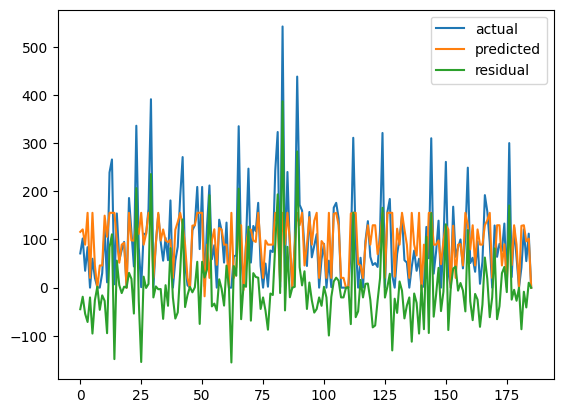

In [38]:
from matplotlib import pyplot as plt

plt.plot(results['actual'], label = 'actual')
plt.plot(results['predicted'], label = 'predicted')
plt.plot(results['residual'], label = 'residual')

plt.legend()

plt.show()

### Evaluating the performance of the model by calculating the Error 
### If you observe since it is regression we use MSE for easy understanding and for comparing values I furthur tuned MSE to RMSE 

In [39]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

rmse=mean_squared_error(y_test, y_pred)**0.5
print(rmse)

6/6 [==============================] - 0s 3ms/step
74.61712107255926


# LSTM 

### If we observe here i am giving input shape 6,3 3 indicates all my three features sales, stocks and price are passing to LSTM at each time step. 6 indicates length of sequence i am giving 6 days data and predicting 7th day value . so that is the reason i gave 6,3 . As the assignment is using multivariate time series model we are passing multiple variables at each time step so 3 features(sales,stock,price) we are pasisng (satisfied multivariable model)

In [40]:
from keras import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(20, input_shape=(6,3)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1920      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,941
Trainable params: 1,941
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.fit(X_train, y_train, epochs=300, batch_size=1, verbose=1)

Epoch 1/300
744/744 [==============================] - 2s 3ms/step - loss: 3744.0837
Epoch 2/300
744/744 [==============================] - 2s 3ms/step - loss: 3778.6921
Epoch 3/300
744/744 [==============================] - 3s 5ms/step - loss: 3792.7134
Epoch 4/300
744/744 [==============================] - 3s 4ms/step - loss: 3846.4702
Epoch 5/300
744/744 [==============================] - 3s 3ms/step - loss: 3811.4697
Epoch 6/300
744/744 [==============================] - 2s 3ms/step - loss: 3891.2761
Epoch 7/300
744/744 [==============================] - 2s 3ms/step - loss: 3833.9980
Epoch 8/300
744/744 [==============================] - 3s 4ms/step - loss: 3939.7336
Epoch 9/300
744/744 [==============================] - 3s 4ms/step - loss: 3743.9321
Epoch 10/300
744/744 [==============================] - 3s 3ms/step - loss: 3662.8062
Epoch 11/300
744/744 [==============================] - 2s 3ms/step - loss: 3646.3198
Epoch 12/300
744/744 [==============================] - 2s 3ms/

In [49]:
y_pred = model.predict(X_test)

y_pred

6/6 [==============================] - 0s 3ms/step


array([[ 94.15731  ],
       [ 96.70991  ],
       [ 65.98621  ],
       [160.36794  ],
       [ 25.07825  ],
       [129.74603  ],
       [ 37.14108  ],
       [  1.1907921],
       [ 85.52518  ],
       [ 65.77681  ],
       [128.90446  ],
       [ 93.860374 ],
       [165.05775  ],
       [165.05725  ],
       [134.8543   ],
       [ 93.805336 ],
       [ 65.73708  ],
       [ 65.77796  ],
       [ 95.750755 ],
       [  4.201561 ],
       [165.01639  ],
       [ 93.80785  ],
       [ 53.720596 ],
       [132.41496  ],
       [142.82547  ],
       [164.88106  ],
       [ 90.33473  ],
       [ 91.358604 ],
       [165.05725  ],
       [166.30096  ],
       [ 24.975048 ],
       [ 96.68133  ],
       [128.2314   ],
       [ 96.254326 ],
       [ 96.68168  ],
       [ 65.509346 ],
       [ 96.679665 ],
       [ 96.876305 ],
       [ 25.083122 ],
       [114.08933  ],
       [130.65175  ],
       [167.88824  ],
       [131.08603  ],
       [ 96.67808  ],
       [ 31.17995  ],
       [  

In [50]:
results = pd.DataFrame()

results['actual'] = y_test.flatten()
results['predicted'] = y_pred.flatten()
results['residual'] = results['actual'] - results['predicted']

results

,actual,predicted,residual
0,71.0,94.157310,-23.157310
1,102.0,96.709908,5.290092
2,35.0,65.986214,-30.986214
3,84.0,160.367935,-76.367935
4,0.0,25.078251,-25.078251
...,...,...,...
181,42.0,96.682671,-54.682671
182,121.0,131.085068,-10.085068
183,55.0,53.720596,1.279404
184,112.0,96.683144,15.316856


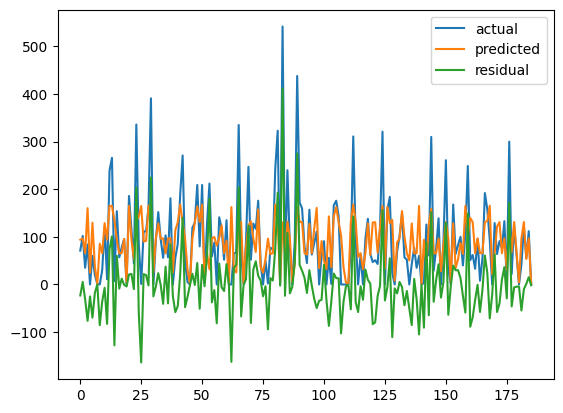

In [51]:
from matplotlib import pyplot as plt

plt.plot(results['actual'], label = 'actual')
plt.plot(results['predicted'], label = 'predicted')
plt.plot(results['residual'], label = 'residual')

plt.legend()

plt.show()

### Evaluating the performance of the model by using MSE error How ever my task is regression MSE is appropriate metric for evaluating . As per class material RMSE is good for comparing i furthur tuned MSE to rmse .

In [52]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

rmse=mean_squared_error(y_test, y_pred)**0.5
print(rmse)

6/6 [==============================] - 0s 3ms/step
73.8525885286663


## Part 3  Analysis (Evaluating the model performances)
1. The assignment is fitting multivariables at each time step in time series.
As i mentioned my data set is about Retail sales forecatsing. I have mentioned the sources of data set. 
Now , I have did the cleaning process and mentioned how many timesteps I am taking.

2. If you observe i am taking 6 days data and predicting 7th day sales. So for create sequence function i am passing numpyarraya and 6 which means cretaing sequence of 6 days .
Then i did rehspaing as our RNN models require three dimesnions.
first observation will tells no of observations
second time steps
third features.
3. If we see the model input shape we are passing 6,3 which indicates 6 days sequences and 3 features (sales, stock,price) I am passing at each time step (example of multivariate time series model).
As per the question in third part of notebook I need to evaluate the performance of the model:
4. if we observe i have taken two models out of 4 which we discussed they are 1. RNN 2. LSTM.
5.I have trained the models RNN,LSTM with one layers and since it is regression the loss function that we need to use is meansquarederror. How ever, as you mentioned in mail it is easy to compare RMSE values I tuned on mse by taking sqaureroot so if you observe in code i am taking ** 0.5 which means RMSE value.
6..The graphs are also plotted by taking actual, predicted, and residual values.
7.If we observe from the graphs and also the error values for the two models:

1. RNN --  74.67
2. LSTM -- 73.85

## From the two models LSTM is having low error than RNN. so, LSTM is considered to be the best model for my data set among the two models which i choosen(RNN,LSTM).
